In [13]:
from torchvision import transforms
import torch

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import CIFAR10

from models.model_final import VisionTransformer, CONFIGS

In [14]:
feature_maps = {}

def hook_fn(module, input, output):
    print(f"Hook triggered for {module}")
    feature_maps[module] = output.detach()

In [ ]:
config = CONFIGS["ViT-Ours_Final"]

model = VisionTransformer(config, num_classes=10)
checkpoint_path = "/home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_3_checkpoint.bin" 
state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件
model.load_state_dict(state_dict)  # 加载模型参数
print(f"Loaded fine-tuned model from {checkpoint_path}")
model.eval()

Loaded fine-tuned model from /home/sichongjie/sichongjie-sub/ViT_torch/output_final/cifar10_No_3_checkpoint.bin


/tmp/ipykernel_1652954/2419150660.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location="cpu")  # 加载权重文件


VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNet_2(
        (block0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (block1): Sequential(
          (0): Residual(
            (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
            (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Residual(
            (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv2): C

In [16]:
for idx, module in enumerate(model.transformer.embeddings.hybrid_model.block1):
    module.register_forward_hook(hook_fn)


Files already downloaded and verified


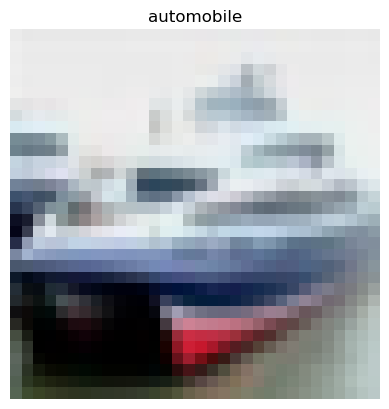

torch.Size([3, 32, 32])


In [ ]:
raw_dataset = CIFAR10(root='./data', train=False, download=True)
classes = raw_dataset.classes

transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

image_idx = 1

x = transform(raw_dataset[image_idx][0])

img = x.permute(1, 2, 0)  # 将 CHW 转换为 HWC

img = img * 0.5 + 0.5  # 逆归一化（从 [-1, 1] 到 [0, 1]）

plt.title(classes[image_idx])
plt.imshow(img)
plt.axis("off")
plt.show()

print(x.shape)

In [18]:
output = model(x.unsqueeze(0))

Hook triggered for Residual(
  (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Hook triggered for Residual(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def visualize_feature_map(feature_map):
    """
    可视化特征图，输出两张图片，每张包含 16x16 的子图。
    """
    feature_map = feature_map[0]  
    total_channels = feature_map.shape[0]
    num_channels_per_image = 256 
    num_rows, num_cols = 16, 16  

    for i in range(2):
        start_channel = i * num_channels_per_image
        end_channel = min((i + 1) * num_channels_per_image, total_channels)
        
        if start_channel >= total_channels:
            break

        selected_channels = feature_map[start_channel:end_channel]
        num_selected = selected_channels.shape[0]

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
        axes = axes.flatten()

        for j in range(num_rows * num_cols):
            if j < num_selected:
                axes[j].imshow(selected_channels[j].cpu().numpy(), cmap='viridis')
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


Visualizing feature map from: Residual(
  (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


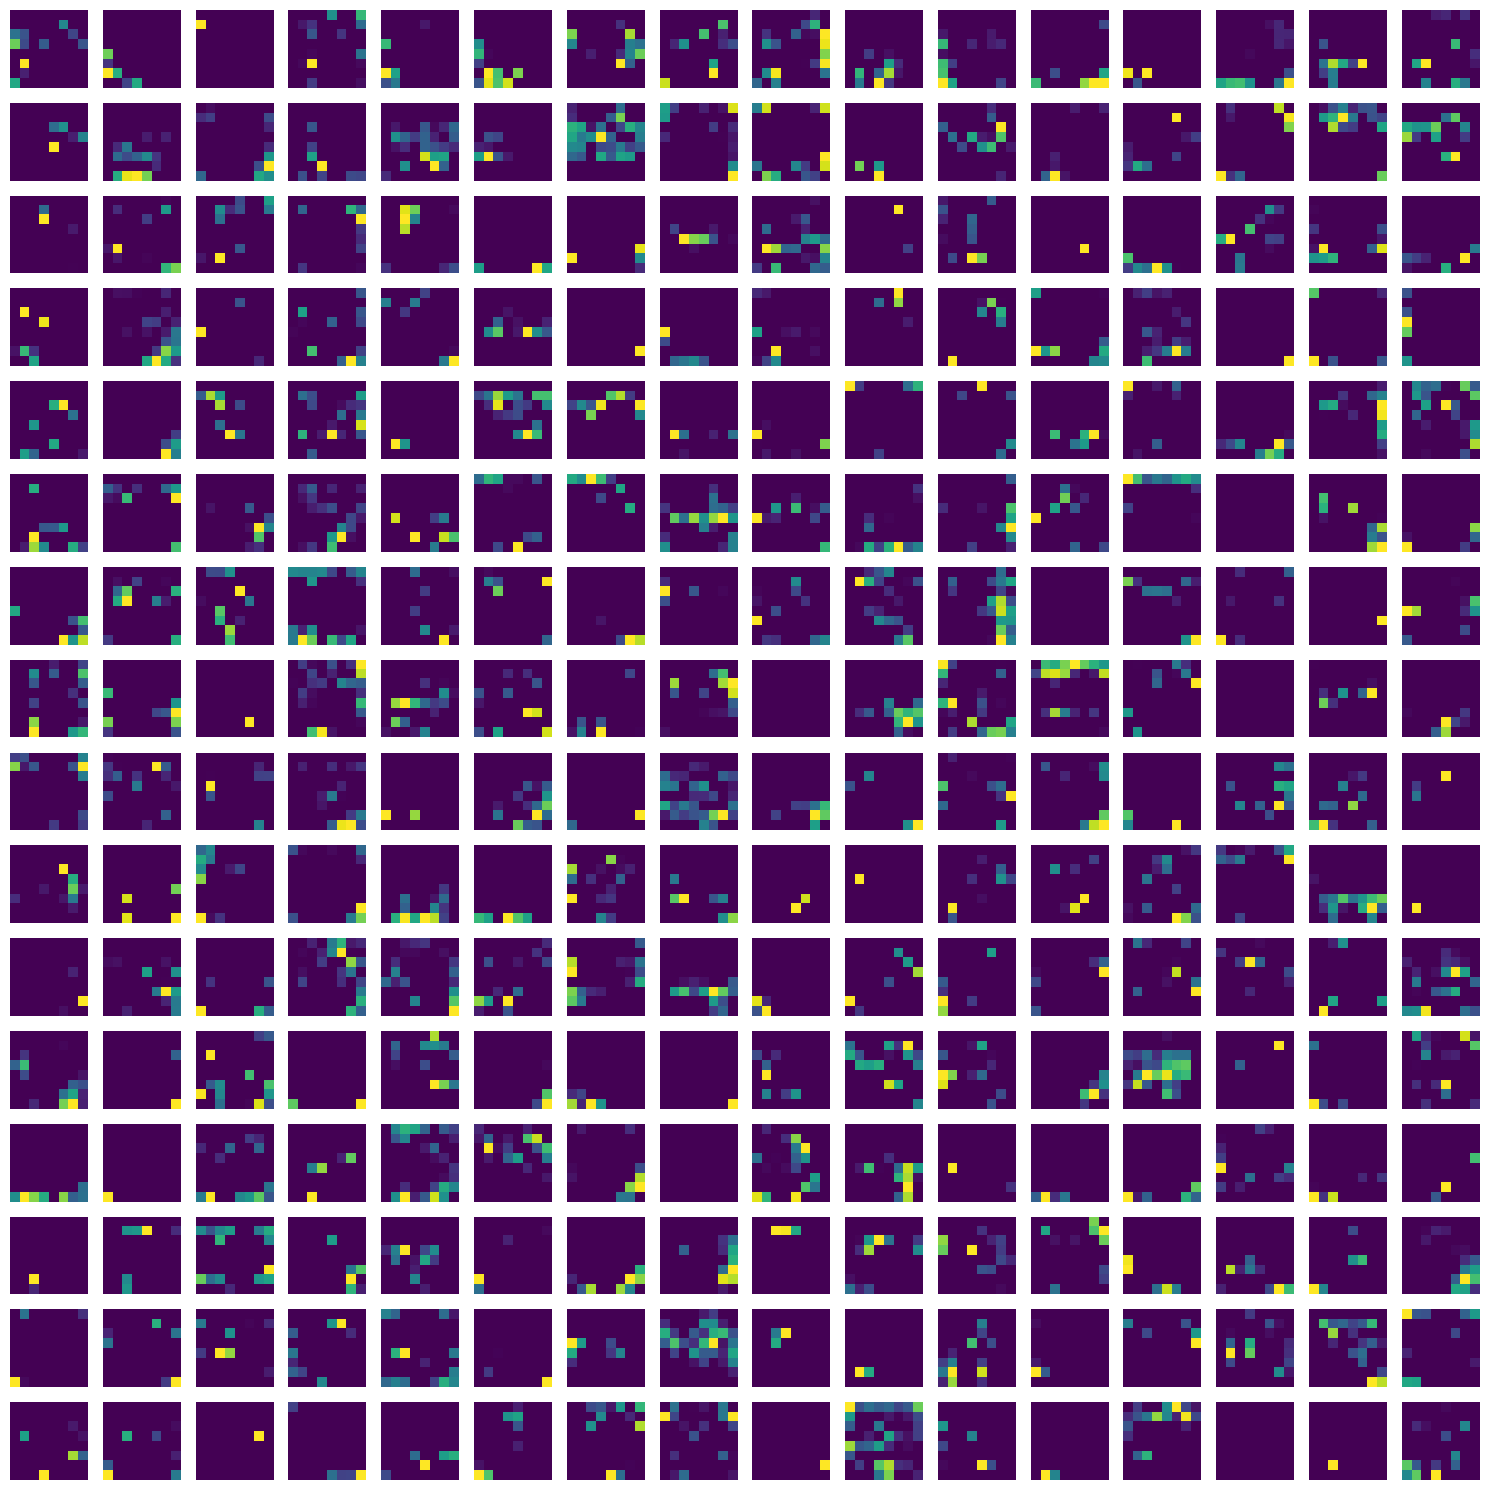

Visualizing feature map from: Residual(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


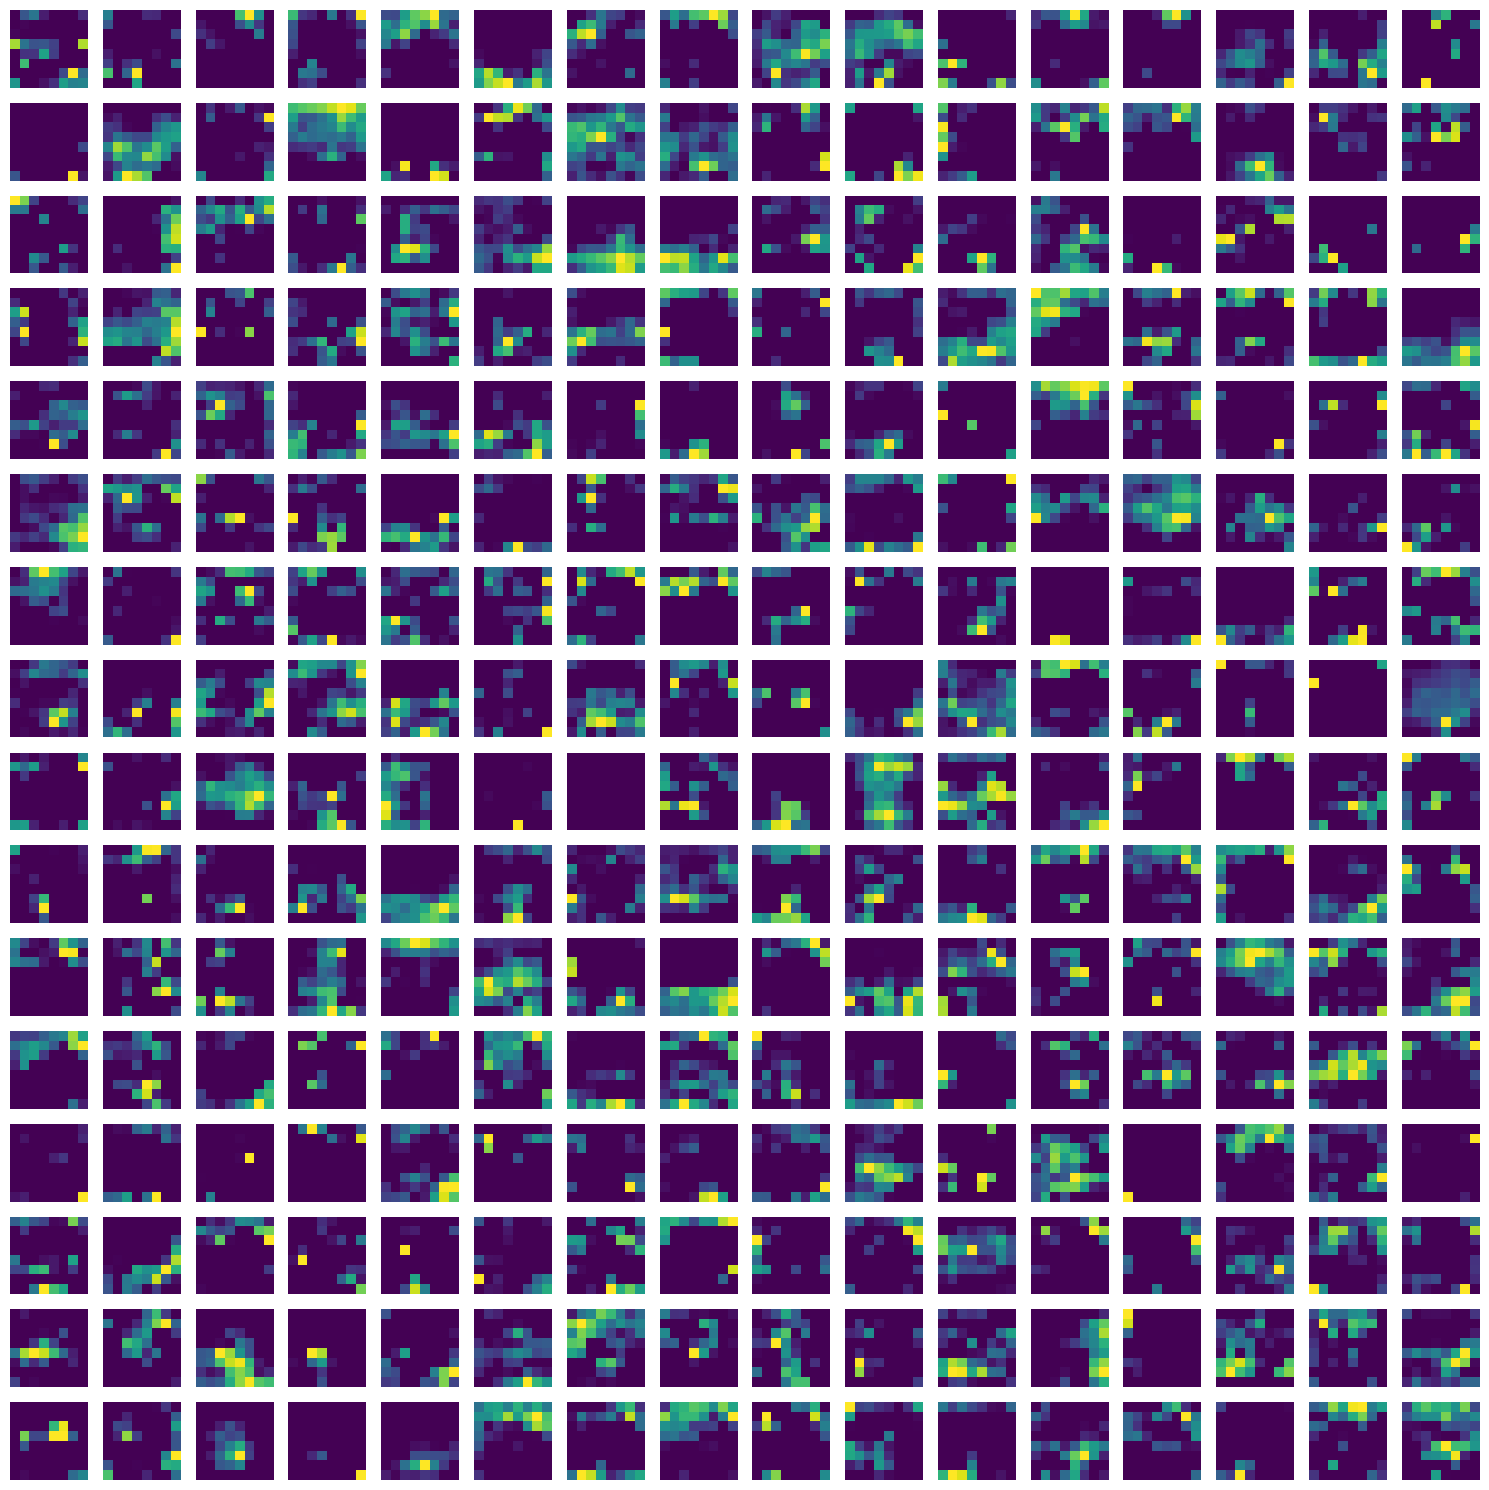

In [20]:
for key, feature_map in feature_maps.items():
    print(f"Visualizing feature map from: {key}")
    visualize_feature_map(feature_map)